In [8]:
import random
from random import sample
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from category_encoders.backward_difference import BackwardDifferenceEncoder
from category_encoders import HelmertEncoder
from transformers import RobertaForMaskedLM, RobertaTokenizer

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset = pd.read_csv('../data/part_10.csv')
dataset = dataset.set_index('CLIENT_IP')
dataset.sample()

,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
CLIENT_IP,,,,,,,
213.87.133.70,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2 like M...,1619,404,REQUEST_COOKIES,REQUEST_COOKIES.LtpaToken2,dheQray3GJpk5DNxBXy75rVgDijoInH1PhjduAIj4Lv zh...,FXDEHmQB5cBXmMW146vO


### пропущенные значения

<AxesSubplot: ylabel='CLIENT_IP'>

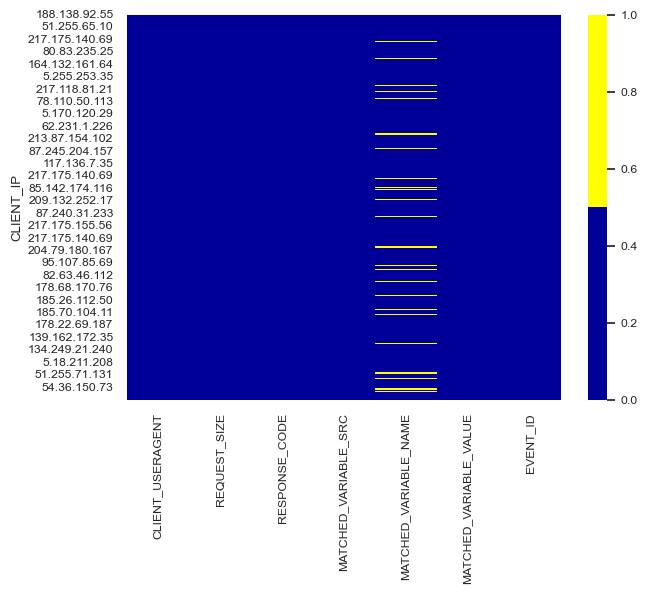

In [4]:
colours = ['#000099', '#ffff00'] 
sns.set(rc={'figure.figsize':(7,5)})
sns.set(font_scale=0.8)
sns.heatmap(dataset.isnull(), cmap=sns.color_palette(colours))

In [5]:
dataset = dataset[~dataset.isnull().all(1)]

for col in dataset.columns:
    pct_missing = np.mean(dataset[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

CLIENT_USERAGENT - 1%
REQUEST_SIZE - 0%
RESPONSE_CODE - 0%
MATCHED_VARIABLE_SRC - 0%
MATCHED_VARIABLE_NAME - 8%
MATCHED_VARIABLE_VALUE - 0%
EVENT_ID - 0%


In [6]:
dataset.isnull().sum()

CLIENT_USERAGENT           294
REQUEST_SIZE                17
RESPONSE_CODE               41
MATCHED_VARIABLE_SRC        81
MATCHED_VARIABLE_NAME     4644
MATCHED_VARIABLE_VALUE     128
EVENT_ID                   145
dtype: int64

### ДУБЛИКАТЫ

In [7]:
dataset[dataset.duplicated(keep=False)]

,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
CLIENT_IP,,,,,,,


In [8]:
dataset = dataset.drop(index=dataset[dataset.duplicated(keep=False)].index)

In [9]:
key = ['CLIENT_USERAGENT',	'RESPONSE_CODE',	'MATCHED_VARIABLE_SRC',	'MATCHED_VARIABLE_NAME',
       'MATCHED_VARIABLE_VALUE',]
print(len(dataset[key][dataset[key].duplicated(keep=False)]))
dataset[key][dataset[key].duplicated(keep=False)].head()

36


,CLIENT_USERAGENT,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE
CLIENT_IP,,,,,
217.175.140.69,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.q,"{\""tags\"":[{\""sizes\"":[{\""width\"":728,\""height..."
188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,200,REQUEST_POST_ARGS,©æ(4È,NaN
188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,200,REQUEST_POST_ARGS,©æ(4È,NaN
217.175.140.69,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.q,"{\""tags\"":[{\""sizes\"":[{\""width\"":728,\""height..."
217.175.140.69,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.q,"{\""tags\"":[{\""sizes\"":[{\""width\"":728,\""height..."


In [11]:
for i in ['EVENT_ID']:
    print(f'всего {i}', len(dataset[i].value_counts().keys()))
    print(f'уникальных {i} ', len(set(dataset[i].value_counts().keys())))

print('всего в датасете записей ', len(dataset))

всего EVENT_ID 54410
уникальных EVENT_ID  54410
всего в датасете записей  57811


In [12]:
# TODO: кодировки поменять?

### CLIENT_USERAGENT

In [13]:
rndm =  np.array(sample(range(len(dataset)), 1))[0]
rndm

54967

In [20]:
dataset['CLIENT_USERAGENT'][rndm:rndm+3].values

array(['Google Update/1.3.33.7;winhttp;cup-ecdsa',
       'Mozilla/5.0 (compatible; AhrefsBot/5.1; +http://ahrefs.com/robot/)',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:57.0) Gecko/20100101 Firefox/57.0'],
      dtype=object)

In [21]:
dataset[dataset['CLIENT_USERAGENT'].isnull()].sample(3)

,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
CLIENT_IP,,,,,,,
87.242.64.149,NaN,82,502,REQUEST_URI,NaN,/system/galery/podogrevpult/_6d4s55hhgou9.jpg,AVdm6uGIq1Ppo9zF8YuU
78.110.50.113,NaN,145,200,REQUEST_URI,NaN,/system/icons/eprodukt/1460.jpg,AVdiZ_Q6q1Ppo9zF5vHI
78.110.50.113,NaN,144,200,REQUEST_URI,NaN,/system/icons/eprodukt/582.jpg,AVdmExnBq1Ppo9zF7yig


In [22]:
dataset['bad_useragent'] = np.where(dataset['CLIENT_USERAGENT'].isna(), 1, 0)
dataset['CLIENT_USERAGENT'] = dataset['CLIENT_USERAGENT'].fillna('Неизвестно')

### MATCHED_VARIABLE_NAME, MATCHED_VARIABLE_VALUE

In [23]:
dataset[['MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME', 'MATCHED_VARIABLE_VALUE' ]].sample(10)

,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE
CLIENT_IP,,,
93.85.178.202,REQUEST_URI,NaN,/www/tasks/9/06/image016.gif
217.182.132.70,REQUEST_PATH,REQUEST_PATH,/yfo/news/2399
130.193.37.14,REQUEST_ARGS_KEYS,%252525252525252526page%252525252525253D1%2525...,%252525252525252526page%252525252525253D1%2525...
188.43.52.163,REQUEST_POST_ARGS,#ÐñϠüi,"}©xî@¤¹,Äc ý¶hòÎvÕ ¶1·ÐTXÏA2ÀýÐ§˿ãY4Y!..."
91.122.55.32,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516356657096
37.46.129.136,REQUEST_POST_ARGS,REQUEST_POST_ARGS.rid,3495992743
185.26.112.50,REQUEST_POST_ARGS,REQUEST_POST_ARGS.rid,3576550464
185.70.104.11,REQUEST_ARGS,NaN,\n--boundaryemae\nContent-Disposition: form-da...
78.47.231.180,REQUEST_GET_ARGS,REQUEST_GET_ARGS.rid,3487417330


In [24]:
len(dataset['MATCHED_VARIABLE_NAME'].value_counts().keys()), len(dataset['MATCHED_VARIABLE_VALUE'].value_counts().keys())

(3209, 57611)

In [25]:
dataset['MATCHED_VARIABLE_NAME'].value_counts()[-3:]

srchPat%255B4%255D                                                 1
/content/goods/item[25]:Comment                                    1
XâO½#*«
WÒ:©¹µMÖ\täÛk17qòmʂ3³vާÏ?æÞÅË
Ëî<èMkq,,ÜÆì½8    1
Name: MATCHED_VARIABLE_NAME, dtype: int64

In [26]:
dataset[dataset['MATCHED_VARIABLE_NAME'].isnull()].sample(3)

,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent
CLIENT_IP,,,,,,,,
217.69.133.242,Mozilla/5.0 (compatible; Linux x86_64; Mail.RU...,384,404,REQUEST_URI,NaN,/news.../page1_81.php,6kuyGmQB5cBXmMW1FAQD,0
62.24.252.133,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,444,200,REQUEST_URI,NaN,/var/files/2/4d2b29ad3ba7f2.14214812_little,AVdWnoNyq1Ppo9zFzJHQ,0
212.37.27.58,psbot-image (+http://www.picsearch.com/bot.html),313,502,REQUEST_URI,NaN,/var/files/0/57a2034dc861f9.18519058,AVdXCdvmq1Ppo9zFzdOF,0


In [27]:
dataset['bad_name'] = np.where(dataset['MATCHED_VARIABLE_NAME'].isna(), 1, 0)
dataset['MATCHED_VARIABLE_NAME'] = dataset['MATCHED_VARIABLE_NAME'].fillna('Неизвестно')

In [28]:
dataset[dataset['MATCHED_VARIABLE_VALUE'].isnull()].sample(3)

,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent,bad_name
CLIENT_IP,,,,,,,,,
¿Jwþ! áFÁ霯N£֬¼ERÚ3¤9ÏDbüù¦Cû©ʱF 6ÿ,AVdZx2MFq1Ppo9zF1IGo,NaN,NaN,NaN,Неизвестно,NaN,NaN,0,1
 ý9g³~7ǼA y~è ÷RN1^¤ZϥØÝ D FÎ ´ >|,AVdtAee3q1Ppo9zF_WoF,NaN,NaN,NaN,Неизвестно,NaN,NaN,0,1
O÷ÆXL ²tþïùïZ±̒.Aç¸î :©¸·{òë£×Ì Ù-Êò9ëCYòAWò©ù¯Îöw»ÒÀsæVÎjîzy맠S)ôÊk°\tEQÔ¢(sï¸\tKL§VIÛø,AVdnwzhJq1Ppo9zF8zmo,NaN,NaN,NaN,Неизвестно,NaN,NaN,0,1


In [29]:
dataset['bad_value'] = np.where(dataset['MATCHED_VARIABLE_VALUE'].isna(), 1, 0)
dataset['MATCHED_VARIABLE_VALUE'] = dataset['MATCHED_VARIABLE_VALUE'].fillna('Неизвестно')

### MATCHED_VARIABLE_SRC

In [30]:
dataset['MATCHED_VARIABLE_SRC'].value_counts()

REQUEST_GET_ARGS                    20812
REQUEST_COOKIES                      9303
REQUEST_HEADERS                      4930
REQUEST_PATH                         4011
REQUEST_ARGS                         3729
RESPONSE_HEADERS                     3364
REQUEST_POST_ARGS                    3304
REQUEST_URI                          3143
REQUEST_XML                          1959
REQUEST_METHOD\';\'REQUEST_CONTE      812
REQUEST_URI\';\'REQUEST_ARGS          666
REQUEST_ARGS_KEYS                     639
REQUEST_JSON                          587
REQUEST_METHOD\';\'REQUEST_HEADE      227
CLIENT_USERAGENT                      133
CLIENT_SESSION_ID                      42
REQUEST_QUERY                          35
RESPONSE_BODY                          22
REQUEST_CONTENT_TYPE                    6
REQUEST_FILES                           5
CLIENT_IP                               1
Name: MATCHED_VARIABLE_SRC, dtype: int64

In [31]:
dataset[dataset['MATCHED_VARIABLE_SRC'] == 'REQUEST_FILES'].sample(5)

,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent,bad_name,bad_value
CLIENT_IP,,,,,,,,,,
37.209.206.246,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,968,301,REQUEST_FILES,file,<?php eval(base64_decode(c3lzdGVtKGJhc2U2NF9kZ...,QTDhNWYBrgKk_RFN4OnO,0,0,0
109.195.49.179,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,159543,200,REQUEST_FILES,reference to,http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd,AVdqyNGwq1Ppo9zF-M6B,0,0,0
203.162.127.193,Mozilla 15,1049,404,REQUEST_FILES,module,PK\n\\x0\\x0\\x0\\x0\\x0RanIjðýU1\\x0\\x0\\x...,wUvZGmQB5cBXmMW1VuHM,0,0,0
96.44.128.250,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,612,404,REQUEST_FILES,Filedata,8D9AAEEC4D8E4439299046B8CDB3F782<?php @eval($...,ejHrNWYBrgKk_RFNsDI6,0,0,0
108.179.199.10,Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US...,8884,301,REQUEST_FILES,file,Neko.php\\x0\\x0\\x0\\x0\\x0\\x0\\x0\\x0\\x0\\...,6jV3NmYBrgKk_RFNxhTc,0,0,0


In [32]:
### комбинированные признаки

In [33]:
# признак MATCHED_VARIABLE_NAME	== MATCHED_VARIABLE_VALUE	
dataset['var_name_eql_value'] = np.where(dataset['MATCHED_VARIABLE_NAME'] == dataset['MATCHED_VARIABLE_VALUE'], 1, 0 )
dataset['var_name_eql_value'].value_counts()

0    57152
1      659
Name: var_name_eql_value, dtype: int64

In [34]:
# TODO: вытаскивать из CLIENT_USERAGENT curl, linux, mozilla 

In [35]:
# проверка, что MATCHED_VARIABLE_SRC в MATCHED_VARIABLE_NAME
dataset['variable_src_in_name'] = dataset.apply(lambda x: str(x.MATCHED_VARIABLE_SRC) in str(x.MATCHED_VARIABLE_NAME), axis=1) * 1
dataset['variable_src_in_name'].value_counts()

1    41839
0    15972
Name: variable_src_in_name, dtype: int64

In [36]:
dataset[dataset['variable_src_in_name'] == 0].sample(3)

,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent,bad_name,bad_value,var_name_eql_value,variable_src_in_name
CLIENT_IP,,,,,,,,,,,,
94.102.4.108,Opera/9.27,294,200,REQUEST_GET_ARGS,vp,"51&&BeNChMaRK(2999999,MD5(NOW()))",GXhpH2QB5cBXmMW1L6fZ,0,0,0,0,0
212.3.152.142,Mozilla/4.0 (compatible; MSIE 7.0; connectpro;...,580,301,CLIENT_USERAGENT,Неизвестно,Mozilla/4.0 (compatible; MSIE 7.0; connectpro;...,-y6TNWYBrgKk_RFNsqZc,0,1,0,0,0
185.70.104.11,Mozilla/4.0 (compatible; Win32; WinHttp.WinHtt...,972,200,REQUEST_ARGS,Неизвестно,\n--boundaryemae\nContent-Disposition: form-da...,AVdWgDUhq1Ppo9zFy9jh,0,1,0,0,0


In [37]:
dataset[dataset['MATCHED_VARIABLE_SRC'].isnull()].sample(3)

,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent,bad_name,bad_value,var_name_eql_value,variable_src_in_name
CLIENT_IP,,,,,,,,,,,,
"> -gOxT""O<Ghèe]Ø È8§q !¹zMƾñ }y ðù!T'|kós;©èE áÐìcqµѭцAÃ,ÈÈëéH77úOP²¸¿ÐôøíÓÌp¶ÎFå_@FråGR Ʀе;u.ö¯É*Qð=pƘ ãVÁàW¸hò",SQL Injection,AVdhop1Rq1Ppo9zF5Ndw,f2b75d93f9732114e1243066945982b6,NaN,Неизвестно,Неизвестно,NaN,0,1,1,1,0
"> -gOxT""O<Ghèe]Ø È8¤d޿ʾñ }y ðù!T'|kós;©èE áÐìcqµѭцAÃ,ÈÈëé@ =M6¾Ô,®/ô=>;tó -³¹Wå¹QԊñ©´-NÝK½«àrJ|\#1¦3¢½ÿ",SQL Injection,AVdYTKwSq1Ppo9zF0T87,71a7ec9c241cee4b50702eefbbbe31d6,NaN,Неизвестно,Неизвестно,NaN,0,1,1,1,0
r®\t÷À5ÞbØÿ,Cross-Site Scripting,AVdbxeDNq1Ppo9zF2JJA,50a68d94b153e22135f74f7377b95cda,NaN,Неизвестно,Неизвестно,NaN,0,1,1,1,0


In [38]:
dataset['bad_src'] = np.where(dataset['MATCHED_VARIABLE_SRC'].isna(), 1, 0)
dataset['MATCHED_VARIABLE_SRC'] = dataset['MATCHED_VARIABLE_SRC'].fillna('Неизвестно')

### EVENT_ID

In [39]:
dataset['unknown_event'] = np.where(dataset['EVENT_ID'].isna(), 1, 0)
dataset['EVENT_ID'] = dataset['EVENT_ID'].fillna('Неизвестно')
dataset.drop(['EVENT_ID'], axis=1, inplace=True)

### REQUEST_SIZE

In [44]:
dataset['REQUEST_SIZE'] = pd.to_numeric(dataset['REQUEST_SIZE'], errors='coerce')
dataset['REQUEST_SIZE'][50]

-1

In [45]:
dataset['bad_req_size'] = np.where(dataset['REQUEST_SIZE'].isna(), 1, 0)

In [46]:
dataset[dataset['REQUEST_SIZE'].isna()][:3]

,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent,bad_name,bad_value,var_name_eql_value,variable_src_in_name,bad_src,unknown_event,bad_req_size
CLIENT_IP,,,,,,,,,,,,,,,


In [47]:
dataset['REQUEST_SIZE'].fillna(-1, inplace=True)
dataset['REQUEST_SIZE'] = dataset['REQUEST_SIZE'].astype('int')

### RESPONSE_CODE

In [48]:
dataset['RESPONSE_CODE'].value_counts()[:1]

200    25771
Name: RESPONSE_CODE, dtype: int64

In [49]:
dataset['RESPONSE_CODE'].value_counts()[-3:]

82b4c42ac7edc647d27de21ceb791491    1
429                                 1
7ccc451ad8a2981f1e6f7eb6a5813246    1
Name: RESPONSE_CODE, dtype: int64

In [50]:
dataset['RESPONSE_CODE'] = pd.to_numeric(dataset['RESPONSE_CODE'], errors='coerce')
dataset['bad_resp_code'] = np.where(dataset['RESPONSE_CODE'].isna(), 1, 0)
dataset[dataset['RESPONSE_CODE'].isna()][:3]

,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,bad_useragent,bad_name,bad_value,var_name_eql_value,variable_src_in_name,bad_src,unknown_event,bad_req_size,bad_resp_code
CLIENT_IP,,,,,,,,,,,,,,,,
"> -gOxT""O<Ghèe]Ø È8 G`Qf¾ñ }y ðù!T'|kós;©èE áÐìcqµѭцAÃ,ÈÈëéO`>y¢¾Ô,®/ô=>;tó -³¹Wå¹QԊñ©´-NÝK½«àrJ|\#1¦3ÎjA^õ¡ÿ",SQL Injection,-1,NaN,Неизвестно,Неизвестно,Неизвестно,Неизвестно,0,1,1,1,0,1,1,0,1
Remote Code Execution,AVdtgf8uq1Ppo9zF_hyd,-1,NaN,Неизвестно,Неизвестно,Неизвестно,Неизвестно,0,1,1,1,0,1,1,0,1
"~@.*"")ۅ",SQL Injection,-1,NaN,Неизвестно,Неизвестно,Неизвестно,Неизвестно,0,1,1,1,0,1,1,0,1


In [51]:
dataset['RESPONSE_CODE'].fillna(-1, inplace=True)
dataset['RESPONSE_CODE'] = dataset['RESPONSE_CODE'].astype('int')

In [52]:
dataset.to_csv('../data/cat_num.csv', index=False)

In [53]:
### UUID?

In [54]:
cat_features = list(dataset.loc[:, dataset.dtypes == object].columns)

num_features = list(set(dataset.columns).difference(set(cat_features)))

In [56]:
# TODO: признак по апишке ?

In [57]:
dataset[cat_features].sample()

,CLIENT_USERAGENT,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
CLIENT_IP,,,,,
217.175.140.69,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,REQUEST_GET_ARGS,REQUEST_GET_ARGS.e,wqT_3QL5AqB5AQAAAwDWAAUBCPqy0dMFEOumpbO2puTkRB...,b1zkHGQB5cBXmMW1j41Z


### кодируем категориальные фичи 

In [58]:
# работает очень долго и отваливается по памяти
# bd = BackwardDifferenceEncoder(drop_invariant=True)
# transformed_cat_f = bd.fit_transform(dataset[cat_features])
# transformed_cat_f.shape

In [51]:
# вытаскиваем эмбеддинги из текста
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large')

def get_token(x):
    """возвращает эмбеддинг текста"""
    return tokenizer(x, add_special_tokens=False)['input_ids']

dataset['random_feature'] = random.sample(range(1, len(dataset) + 1), len(dataset))

In [52]:
# TODO: как-то обрабаывать List[str] и List[List[str]] ?
for col in cat_features:
    dataset[col] = dataset[col].astype('str')

In [53]:
text_cols = cat_features

In [54]:
%%time
for col in text_cols:
    if col != text_cols[-1]:
        print(col, ' -->')
    dataset[col + '_median'] = dataset[col].apply(lambda x: np.median(get_token(x)))
    dataset[col + '_sum'] = dataset[col].apply(lambda x: np.sum(get_token(x)))
    dataset[col + '_mean'] = dataset[col].apply(lambda x: np.mean(get_token(x)))
    dataset[col + '_mode'] = dataset[col].apply(lambda x: stats.mode(get_token(x)).mode[0])
    dataset[col + '_min'] = dataset[col].apply(lambda x: np.min(get_token(x)))
    dataset[col + '_max'] = dataset[col].apply(lambda x: np.max(get_token(x)))
    dataset[col + '_std'] = dataset[col].apply(lambda x: np.std(get_token(x)))

CLIENT_USERAGENT  -->
MATCHED_VARIABLE_SRC  -->
MATCHED_VARIABLE_NAME  -->
MATCHED_VARIABLE_VALUE  -->
CPU times: user 4min 27s, sys: 389 ms, total: 4min 28s
Wall time: 4min 30s


In [55]:
for col in cat_features:
    dataset[col + '_count'] = dataset[col].map(dataset.groupby(col).size())

num_features = list(set(dataset.columns).difference(set(cat_features)))
num_features.append('CLIENT_IP')
len(num_features)

54

In [ ]:
source_dataset = pd.read_csv('../data/part_10.csv')

In [17]:
most_similar_ind = list(dataset.sort_values(['MATCHED_VARIABLE_SRC_std', 'MATCHED_VARIABLE_SRC_max'])[:10].index)
source_dataset[source_dataset['CLIENT_IP'].isin(most_similar_ind)].sample(10)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
53495,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,106094,502,REQUEST_POST_ARGS,º¡/váüìd́_öLÊ{À©kþ·ë^\Zõ¹±3,NaN,NaN
23097,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,147956,200,REQUEST_POST_ARGS,ããVª oÏ3?8Ë ��±À'40|Koi$¬è~üÄuÉ...,7 }ê,AVdqbAk6q1Ppo9zF-Ay0
2353,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,92532,200,REQUEST_ARGS_KEYS,úþò9-áóB¨Nø×æçwSЊ<AáØÆãk£_£ X ×Ҙ <Ñ_K...,úþò9-áóB¨Nø×æçwSЊ<AáØÆãk£_£ X ×Ҙ <Ñ_K...,AVddFN_dq1Ppo9zF2_RF
41513,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,109245,200,REQUEST_POST_ARGS,½üâr½ÈW­\\n*(Wp÷­1WQêÍFa{Qåj_/h9¨¹`×%...,JÉrd<tQP³SP3Î}«£Â£v8\nióAåóϭ[7 »LWÉÁæ£...,AVdcCUF9q1Ppo9zF2TSP
1921,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,113671,200,REQUEST_POST_ARGS,,©´Üf%<RS1N æ¦ LÔT´®ÎP·Ҥ,NaN
37547,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,82452,200,REQUEST_ARGS_KEYS,"¯¢ü8""môLÅc/8UO!7Áä ãô¤>}ó_×ô á^¡¨é±Zivi...","¯¢ü8""môLÅc/8UO!7Áä ãô¤>}ó_×ô á^¡¨é±Zivi...",AVdcbie-q1Ppo9zF2lW9
2423,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,91480,200,REQUEST_ARGS_KEYS,ÑoDÌV2óuTòq @Î8?J_<#ísÿ,ÑoDÌV2óuTòq @Î8?J_<#ísÿ,AVddi2YJq1Ppo9zF3P75
36873,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,95265,200,REQUEST_ARGS_KEYS," ¼ëkËx·ޮ@È,X«G| J%Ԣ<Þ4üTÊ?¥>Tº/¸_|..."," ¼ëkËx·ޮ@È,X«G| J%Ԣ<Þ4üTÊ?¥>Tº/¸_|...",AVdYCdm4q1Ppo9zF0JI3
15814,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,132657,200,REQUEST_POST_ARGS,Ø »v1×¹ô­ûÍqîí~Ïåm'nçߝÛpzmÉ µë¿Ø:güûÿ,= è/ì 7þ}ÿ,AVdjj3Dkq1Ppo9zF6Toy
55136,188.43.52.163,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,92664,200,REQUEST_POST_ARGS,úà*Bbóü¤,G\Ùÿ,AVdY7gz9q1Ppo9zF0q3B


In [19]:
most_similar_ind = list(dataset.sort_values(['MATCHED_VARIABLE_SRC_std', 'MATCHED_VARIABLE_SRC_max'], ascending=False)[:5].index)
source_dataset[source_dataset['CLIENT_IP'].isin(most_similar_ind)].sample(10)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
13063,Remote Code Execution,AVdoR85uq1Ppo9zF9FLF,df11e08fcf256da60f27241da3d7a133,NaN,NaN,NaN,NaN,NaN
50,"> -gOxT""O<Ghèe]Ø È8 G`Qf¾ñ }y ðù!T...",SQL Injection,AVdYz8-Wq1Ppo9zF0mzK,2f53b17df6da6bf9aeec27b0d87413c4,NaN,NaN,NaN,NaN
35560,Remote Code Execution,AVdsrjKRq1Ppo9zF_Ms5,780c8c6230c0f487f84dcd98a5315392,NaN,NaN,NaN,NaN,NaN
11695,Remote Code Execution,AVdh6mHyq1Ppo9zF5Zg-,57e7c5ef3f48e338deff1b3ff9d91b26,NaN,NaN,NaN,NaN,NaN
45263,Remote Code Execution,AVdXZBNLq1Ppo9zFzs2S,d28f1d7c5318d6da5539f35da8989888,NaN,NaN,NaN,NaN,NaN
39346,Remote Code Execution,AVddXYBdq1Ppo9zF3IC6,00ad660f24ebd23679e1ae3d8d15c1a0,NaN,NaN,NaN,NaN,NaN
49039,Remote Code Execution,AVdc--Sqq1Ppo9zF27qm,37ad43df16c285c4ec9010a10b387e70,NaN,NaN,NaN,NaN,NaN
34993,Remote Code Execution,AVdcZcsOq1Ppo9zF2j0H,e6559616459278cd3606d911ccb63500,NaN,NaN,NaN,NaN,NaN
4917,Remote Code Execution,AVdrihgNq1Ppo9zF-n8K,47dcc12389bccd49ba2a60b2e0a56e98,NaN,NaN,NaN,NaN,NaN
55896,Remote Code Execution,AVdcvSoAq1Ppo9zF2y_z,1cc6e2fe3fcc728c132e90c43d6b787d,NaN,NaN,NaN,NaN,NaN


In [56]:
dataset[num_features].to_csv('../data/embeddings.csv', index=False)